In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, Flatten, Reshape, Cropping1D
import pandas as pd
import numpy as np
import data_preprocess
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [30]:
df_n0 = pd.read_csv("data/final/normal/NormalMotor150mm_20.csv", header=None)
df_n1 = pd.read_csv("data/final/normal/NormalMotor150mm_30.csv", header=None)
df_n2 = pd.read_csv("data/final/normal/NormalMotor150mm_50.csv", header=None)
df_n3 = pd.read_csv("data/final/normal/NormalMotor150mm_60.csv", header=None)

df_n4 = pd.read_csv("data/final/1936/normal/NormalMotor_1936_20.csv", header=None)
df_n5 = pd.read_csv("data/final/1936/normal/NormalMotor_1936_30.csv", header=None)
df_n6 = pd.read_csv("data/final/1936/normal/NormalMotor_1936_40.csv", header=None)
df_n7 = pd.read_csv("data/final/1936/normal/NormalMotor_1936_50.csv", header=None)

In [31]:
df_a0 = pd.read_csv("data/final/ambient/AmbientMotorsOff_1913.csv", header=None)
df_a1 = pd.read_csv("data/final/1936/ambient/MotorOff_1936_20minTest.csv", header=None)

In [32]:
# data, channels, sr, hz, type
data_df = [
    [df_n0, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_n1, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_n2, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_n3, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_n4, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_n5, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_n6, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_n7, (0, 1, 2, 3), 20000, (20,), 'nnnn'],

    [df_a0, (0, 1, 2, 3), 20000, (20,), 'nnnn'],
    [df_a1, (0, 1, 2, 3), 20000, (20,), 'nnnn']
]

In [33]:
import importlib
importlib.reload(data_preprocess)

<module 'data_preprocess' from 'c:\\Users\\rarora\\DataspellProjects\\PredictiveAnalysis\\data_preprocess.py'>

In [34]:
data_interval = 4
preprocessor = data_preprocess.Preprocessor(max_freq=600, kaiser_beta=10, overlap=2)

In [35]:
dataset = preprocessor.compute_preprocess(data_df, data_interval, shuffle=True, keep_channels_separate=False)

1 of 10 finished
2 of 10 finished
3 of 10 finished
4 of 10 finished
5 of 10 finished
6 of 10 finished
7 of 10 finished
8 of 10 finished
9 of 10 finished
10 of 10 finished


In [36]:
X = dataset[:, :-2]
X_train, X_test = train_test_split(X, test_size=0.10)
X_train, X_val = train_test_split(X, test_size=0.10)
#scaler = StandardScaler()
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = X_test
X_val = scaler.transform(X_val)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(21733, 2401)
(2415, 2401)
(2415, 2401)


In [37]:
def reset():
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    try:
        del encoder
        del encoded
        del decoder
        del decoded
        del autoencoder
    except:
        pass

In [38]:
# create encoder
reset()
input_shape_encoder = (X_train.shape[1],1)
input_layer_encoder = keras.Input(shape=input_shape_encoder)

encoded = Conv1D(8, kernel_size=3, activation='relu', padding='same', use_bias=True)(input_layer_encoder)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Conv1D(8, kernel_size=3, activation='relu', padding='same', use_bias=True)(encoded)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Flatten()(encoded)
encoded = Dense(1000, activation='relu', use_bias=True)(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(500, activation='relu', use_bias=True)(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(200, activation='relu', use_bias=True)(encoded)

encoder = keras.Model(input_layer_encoder, encoded)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2401, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2401, 8)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1200, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1200, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1200, 8)        │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 600, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     4,801,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │       100,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,932 (20.61 MB)

 Trainable params: 5,401,932 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
input_layer_decoder = keras.layers.Input(shape=encoder.output.shape[1:])
decoded = Dense(500, activation='relu', use_bias=True)(input_layer_decoder)
encoded = Dropout(0.1)(encoded)
decoded = Dense(1000, activation='relu', use_bias=True)(input_layer_decoder)
encoded = Dropout(0.1)(encoded)
decoded = Dense(4800, activation='relu', use_bias=True)(decoded)
decoded = Reshape(target_shape=(600, 8))(decoded)
decoded = UpSampling1D(size=2)(decoded)
decoded = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='valid', use_bias=True)(decoded)
decoded = UpSampling1D(size=2)(decoded)
decoded = Conv1DTranspose(8, kernel_size=3, activation='relu', padding='same', use_bias=True)(decoded)
decoded = Conv1D(1, kernel_size=3, activation='linear', padding='valid', use_bias=True)(decoded)
decoded = Cropping1D(cropping=(0, 1))(decoded)

decoder = keras.Model(input_layer_decoder, decoded)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │       201,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4800)           │     4,804,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 600, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 1200, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1202, 8)        │           200 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 2404, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 2404, 8)        │           200 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2402, 1)        │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 2401, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,006,225 (19.10 MB)

 Trainable params: 5,006,225 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# create autoencoder
encoded_data = encoder(input_layer_encoder)
decoded_data = decoder(encoded_data)
autoencoder = keras.Model(inputs=input_layer_encoder, outputs=decoded_data)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2401, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 200)            │     5,401,932 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 2401, 1)        │     5,006,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,408,157 (39.70 MB)

 Trainable params: 10,408,157 (39.70 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss = keras.losses.MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [44]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
history = autoencoder.fit(X_train, X_train, epochs=40, batch_size=64, shuffle=True, validation_data=(X_val, X_val), callbacks=[callback])

Epoch 1/40
340/340 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 3.9858e-05 - loss: 1.4697 - val_accuracy: 0.0000e+00 - val_loss: 0.9278
Epoch 2/40
340/340 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 3.9358e-05 - loss: 0.8675 - val_accuracy: 0.0000e+00 - val_loss: 0.8357
Epoch 3/40
340/340 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 4.0335e-05 - loss: 0.8067 - val_accuracy: 0.0000e+00 - val_loss: 0.7820
Epoch 4/40
340/340 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 3.9175e-05 - loss: 0.7731 - val_accuracy: 0.0000e+00 - val_loss: 0.7587
Epoch 5/40
340/340 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 3.7828e-05 - loss: 0.7599 - val_accuracy: 0.0000e+00 - val_loss: 0.7364
Epoch 6/40
340/340 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 3.8145e-05 - loss: 0.7387 - val_accuracy: 0.0000e+00 - val_loss: 0.7187
Epoch 7/40
340/340 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 3.9077e-05 - loss: 0.7105 - val_accuracy: 0.0000e+00 - val_loss: 0.7128
Epoch 8/40
340/340 ━━━━━━━━━━━━━━━

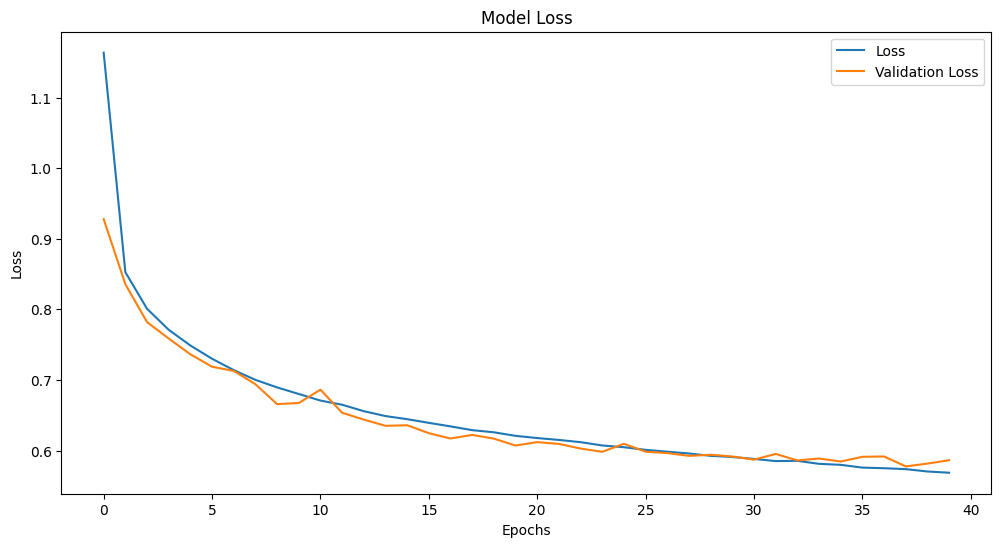

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [58]:
X_test_transformed = scaler.transform(X_test)
average_test_fft = np.mean(X_test, axis=0)
average_predict_fft = np.mean(autoencoder.predict(X_test_transformed), axis=0)
autoencoder.evaluate(X_test_transformed, X_test_transformed)

 9/76 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 4.0700e-05 - loss: 0.5627


[0.557257890701294, 3.552697307895869e-05]

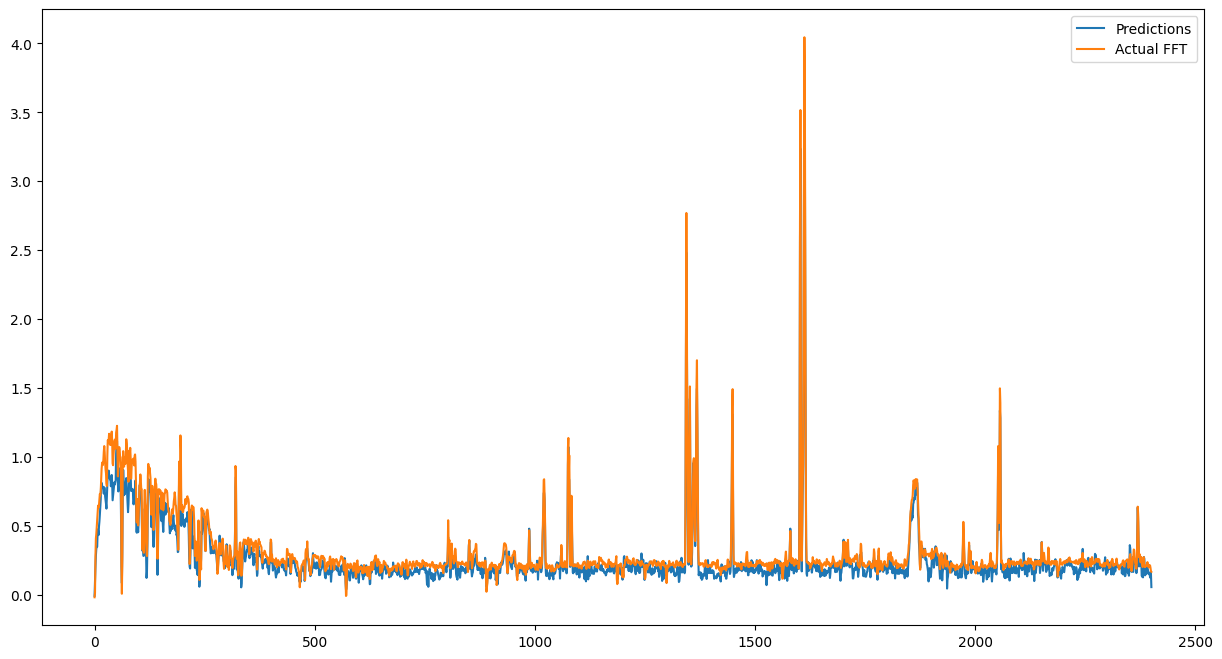

In [59]:
plt.figure(figsize=(15,8))
plt.plot(average_predict_fft, label="Predictions")
plt.plot(np.mean(X_test_transformed, axis=0), label="Actual FFT")
plt.legend(loc='upper right')
plt.show()

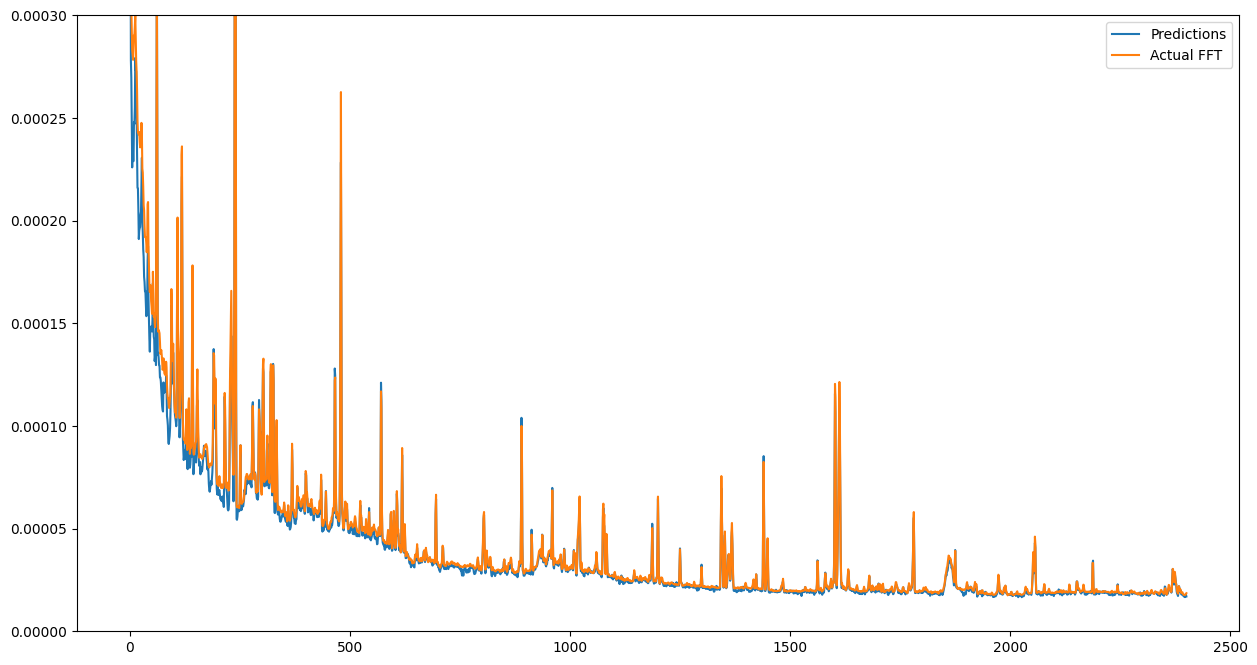

In [60]:
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform([average_predict_fft.reshape(-1,)])[0], label="Predictions")
plt.plot(average_test_fft, label="Actual FFT")
plt.legend(loc='upper right')
#plt.xlim(0, 500)
plt.ylim(0, 0.0003)
plt.show()

In [61]:
df_a2 = pd.read_csv("data/final/1936/ambient/AmbientNoise_Testing_Autoencoder_and_Noise_Cancellation.csv", header=None)

In [62]:
test_df = [
    [df_a2, (0,), 20000, (20,), 'n']
]

In [63]:
dataset_test = preprocessor.compute_preprocess(test_df, data_interval=data_interval, shuffle=True, keep_channels_separate=False)

1 of 1 finished


In [64]:
dataset_test1 = preprocessor.compute_preprocess([[df_a2, (1,), 20000, (20,), 'n']], data_interval=data_interval, shuffle=True, keep_channels_separate=False)
actual1 = np.mean(dataset_test1[:, :-2], axis=0)

1 of 1 finished


In [65]:
actual = np.mean(dataset_test[:, :-2], axis=0)

In [66]:
pred = scaler.inverse_transform(autoencoder.predict(scaler.transform(dataset_test[:, :-2])).mean(axis=2)).mean(axis=0)
#pred = np.mean(scaler.inverse_transform(autoencoder.predict(scaler.transform(dataset_test[:, :-2]))), axis=0)
autoencoder.evaluate(scaler.transform(dataset_test[:, :-2]), scaler.transform(dataset_test[:, :-2]))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.4562


[0.45669126510620117, 0.0]

In [71]:
print(pred.shape)
print(actual.shape)
mse = np.mean((pred - actual)**2)
print(mse)

(2401,)
(2401,)
5.170258028514893e-10


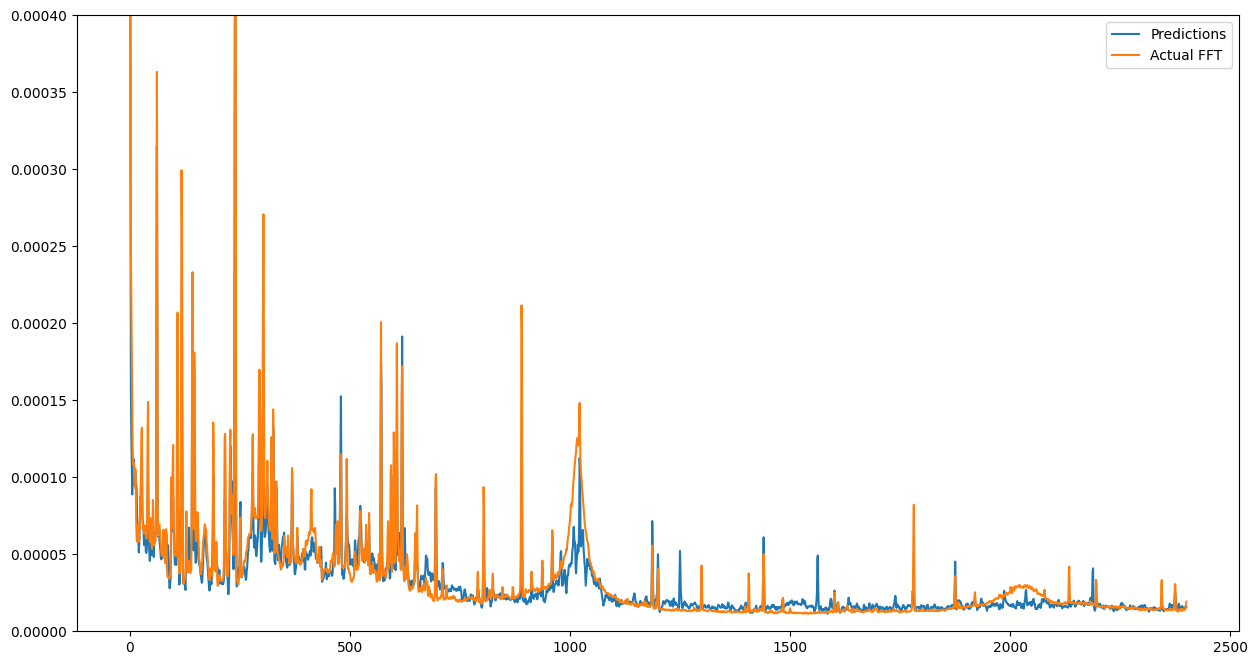

In [68]:
plt.figure(figsize=(15,8))
plt.plot(pred, label="Predictions")
plt.plot(actual, label="Actual FFT")
plt.legend(loc='upper right')
#plt.xlim(0, 500)
plt.ylim(0, 0.0004)
plt.show()

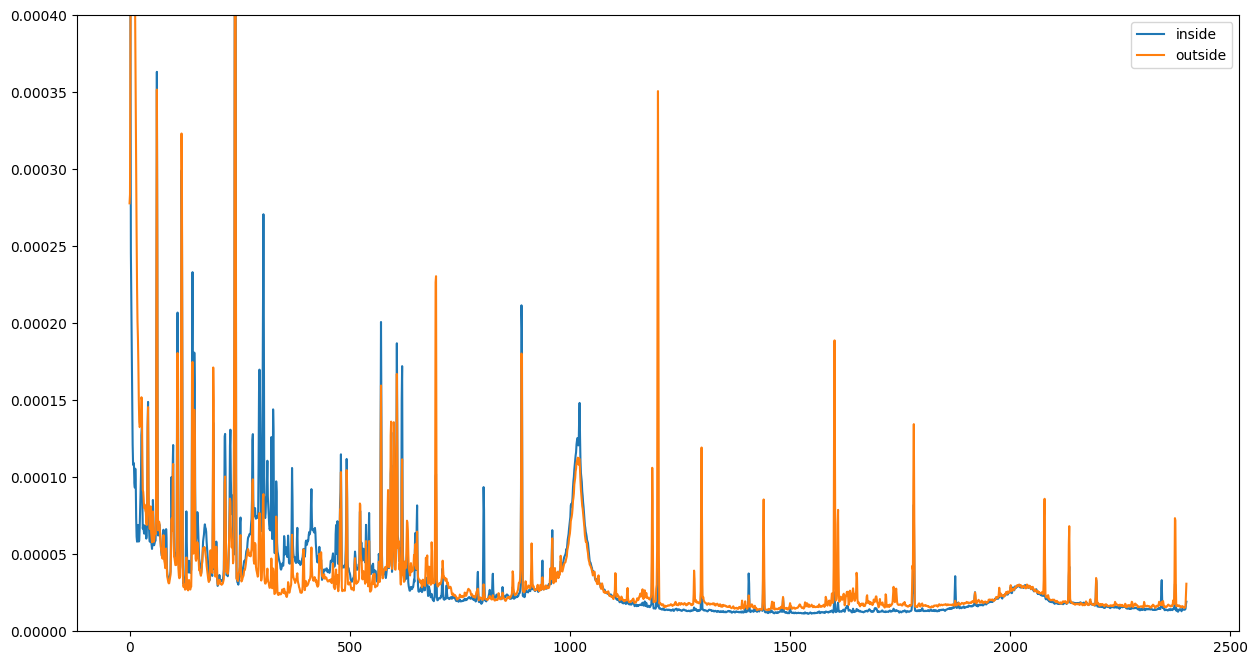

In [69]:
plt.figure(figsize=(15,8))
plt.plot(actual, label="inside")
plt.plot(actual1, label="outside")
plt.legend(loc='upper right')
#plt.xlim(0, 1000)
plt.ylim(0, 0.0004)
plt.show()